In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..')))
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf

In [2]:
from bayesflow.forward_inference import *
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer

<h1>Introduction</h1>
<br>

In our [previous tutorial](./Covid19_Initial_Posterior_Estimation.ipynb), we saw how to perform <strong>amortized posterior estimation</strong> on the parameters of a compartmental model for disease outbreaks. In this tutorial, we will perform <strong>prior sensitivity analysis</strong> on our posterior inference using for the first time the `prior_batchable_context` quantity.

Assessing a model's sensitivity can be quite challenging in Bayesian analysis, since it typically requires re-estimating the model multiple times on the same data. 
Naturally, such an approach scales poorly in scenarios where estimating a model even <strong>once</strong> is prohibitively slow.
While problems of efficiency can be somewhat alleviated in the context of likelihood-based Bayesian inference using Markov chain Monte Carlo (MCMC), the computational burden of refitting models becomes even heavier in simulation-based scenarios. 

Both core quantities in Bayesian inference, namely, likelihood and prior, depend on some implicit context variables which are considered fixed and thus not further specified as explicit conditioning variables.
Typical examples for prior context variables might be as simple as the prior scale (i.e., dispersion) of admissible parameter values or as complex as discrete sets of qualitative expert knowledge.
Typical examples for likelihood context variables include various structural decisions regarding the transformation or exogenous experimental factors, such as design matrices, indicator variables, or time scales.
In the `BayesFlow` library, such factors are considered <strong>context</strong> and should be implemented via `ContextGenerator` instances. Both `Prior` and `Simulator` instances support context generators.

Why is sensitivity analysis important? Modelers might disagree regarding the <em>right</em> set of context variables. 
For instance, when modeling emerging pandemics, different experts might choose to incorporate different prior knowledge about unknown disease parameters in their analysis and thereby arrive at conflicting substantive conclusions based on the same data.
Certainly, the sensitivity of Bayesian inference will depend on the interplay between various factors, such as the model family or the amount of available data. 
However, in most real-world applications, this interplay is too complex to allow for a straightforward (analytical) calculation of sensitivity.
Thus, it is often desirable to explicitly asses the sensitivity of Bayesian analysis to possible choices of context variables by varying the latter along reasonable dimensions and then quantifying the consequences for the resulting inference.
It is this assessment that we will illustrate in this notebook.

## Defining the Generative Model

We will use the exactly same compartmental model as implemented in our [previous tutorial](./Covid19_Initial_Posterior_Estimation.ipynb). Our underlying model distinguishes between susceptible, $S$, infected, $I$, and recovered, $R$, individuals with infection and recovery occurring at a constant transmission rate $\lambda$ and constant recovery rate $\mu$, respectively. The model dynamics are governed by the following system of ODEs:

$$
\begin{align}
    \frac{dS}{dt} &= -\lambda\,\left(\frac{S\,I}{N}\right) \\
    \frac{dI}{dt} &= \lambda\,\left(\frac{S\,I}{N}\right) - \mu\,I \\
    \frac{dR}{dt} &= \mu\,I,
\end{align}
$$

with $N = S + I + R$ denoting the total population size. For the purpose of forward inference (simulation), we will use a time step of $dt = 1$, corresponding to daily case reports. In addition to the ODE parameters $\lambda$ and $\mu$, we consider a reporting delay parameter $L$ and a dispersion parameter $\psi$, which affect the number of reported infected individuals via a negative binomial disttribution (https://en.wikipedia.org/wiki/Negative_binomial_distribution).

Let's first define a global singleton for accessing the `numpy` random number generator:

In [3]:
RNG = np.random.default_rng(2022)

### Prior

Our prior is the same as in our [previous notebook](./Covid19_Initial_Posterior_Estimation.ipynb), with the difference of a new argument called `alpha`. What this argument does is to scale each marginal prior $j$ in the following way $p(\theta_j) \rightarrow p(\theta_j)^{\alpha_j}$.

The above transformation is called power scaling and is descrtibed in more detial in the paper by Noa Kallioinen, Topi Paananen, Paul-Christian Bürkner, and Aki Vehtari:

<em>Detecting and diagnosing prior and likelihood sensitivity with power-scaling</em> (https://arxiv.org/abs/2107.14054)

Essentially, the power scaling method expands or shrinks the prior pdf, thus assuming a sort of <strong>hierarchical prior</strong> with adaptive sharpness. However, differently to hierarchical Bayesian models, we will not estimate the hyerparameter $\alpha$, but probe our results with different values of $\alpha$ in some meaningful range (here $\alpha \in [0.5 - 2]$).
The neat trick is this: we will perform <strong>amortized prior sensitivity analysis</strong>. Instead of training one `AmortizedPosterior`, we will include $\alpha$ in the generative process and treat it as a context variable over which to amortize. This means, that the scaling factors will simply be concatednated with the outputs of the summary network and passed on to the inference network. In this way, upon convergence, we end up with an $\alpha$-aware inference network, which can yield a posterior for each $\alpha$ we supply during inference.

#### Context Generator Function


During training, we will generate the scaling parameters from a continuous uniform distribution:

$$
\alpha_j \sim \mathcal{U}(0.5, 2)
$$

In this way, the inference network will see both simulations with a narrower prior ($\alpha > 1$) and a wider prior ($\alpha < 1$) than our original prior choice ($\alpha = 1$).

In [32]:
def alpha_gen():
    """ Generates power-scaling parameters from a uniform distribution.
    """
    return RNG.uniform(0.5, 2, size=5)

#### Prior Generator Function

We can now also define the function which will generate random draws from the prior. Notice the additional argument specifying the vector of $\alpha$-scaling parameters. Note also, that scaling different pdfs has different effect on the corresponding parametrs. For instance, performing power scaling on an [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) pdf simply means dividing it's shape parameters by $\alpha$. Further examples are given in https://arxiv.org/abs/2107.14054.

In [33]:
def model_prior(alpha):
    """ Generates random draws from the prior given an alpha scaling parameter. Each marginal
    prior has its own scaling parameter. See the paper linked below for details:
    
    https://arxiv.org/abs/2107.14054
    """
    
    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5 / np.sqrt(alpha[0]) )
    mu = RNG.lognormal(mean=np.log(1/8), sigma=0.2 / np.sqrt(alpha[1]) )
    D = RNG.lognormal(mean=np.log(8), sigma=0.2 / np.sqrt(alpha[2]) )
    I0 = RNG.gamma(shape=2*alpha[3] - alpha[3] + 1, scale=20/alpha[3])
    psi = RNG.exponential(5/alpha[4])
    return np.array([lambd, mu, D, I0, psi])

Great! We can now connect the context generating function with the prior sampler using `BayesFlow` wrappers:

In [12]:
prior_context = ContextGenerator(batchable_context_fun=alpha_gen)
prior = Prior(model_prior, prior_context)

When we now call the `Prior` object, we can see that the entry `batchable_context` in the output dictionary is filled with the scaling parameters used to generate each random draw. The context is dubbed <em>batchable</em>, because for each random draw from the prior in a batch of simulations, there is a corresponding context variable. In contrast, a `non_batchable_context` would be shared across all simulated quantities within a batch.

In [16]:
prior(2)

{'prior_draws': array([[ 0.33610512,  0.12001227,  7.13881526, 60.35291708,  3.23956216],
        [ 0.50102922,  0.12348521, 10.08823068, 44.44636353,  0.85205942]]),
 'batchable_context': [array([0.62513734, 1.17675062, 0.74885141, 0.50594303, 0.94169066]),
  array([1.33514958, 1.7993603 , 0.81417343, 1.2814965 , 1.25550107])],
 'non_batchable_context': None}

Notice, that the context variables are returned as a `list` type. This is done in order to deal with cases where the context variables cannot be coerced to a rectangular array or tensor. Our `configurator` should take care of this!

During training, we will also standardize the prior draws, that is, ensure zero means and unit scale. We will do this purely for technical reasons - neural networks like scaled values. In addition, our current prior ranges differ vastly, so each parameter will contribute disproportionately to the loss function. Here, we will use the `estimate_means_and_stds()` method of a `Prior` instance, which will estimate the prior means and standard deviations from random draws. We could have also just taken the analytic marginal means and standard deviations, but these may not be available in all settings (e.g., implicit priors).

In [38]:
prior_means, prior_stds = prior.estimate_means_and_stds()

### Simulator (Implicit Likelihood Function)

Our simulator remains unchanged from the one specified in our [previous notebook](./Covid19_Initial_Posterior_Estimation.ipynb):

In [39]:
from scipy.stats import nbinom

def convert_params(mu, phi):
    """ Helper function to convert mean/dispersion parameterization of a negative binomial to N and p, 
    as expected by numpy.
    
    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    
    r = phi
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def stationary_SIR(params, N, T, eps=1e-5):
    """Performs a forward simulation from the stationary SIR model given a random draw from the prior,
    """
    
    # Extract parameters and round I0 and D
    lambd, mu, D, I0, psi = params
    I0 = np.ceil(I0)
    D = int(round(D))
    
    # Initial conditions
    S, I, R = [N-I0], [I0], [0]
    
    # Reported new cases
    C = [I0]
    
    # Simulate T-1 tiemsteps
    for t in range(1, T+D):
        
        # Calculate new cases
        I_new = lambd * (I[-1]*S[-1]/N)
        
        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu*I[-1], 0., N)
        R_t = np.clip(R[-1] + mu*I[-1], 0., N)
        
        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)
    
    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return C_obs[:, np.newaxis]

### Loading Real Data

We will define a simple helper function to load the actually reported cases for the first 2 weeks in Germany.

In [40]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""
    
    confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')

    date_data_begin = datetime.date(2020,3,1)
    date_data_end = datetime.date(2020,3,15)
    format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                     str(date_py.year)[2:4])
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs =  np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                            date_formatted_begin:date_formatted_end])[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

Again, we can collect the simulator settings, together with the observed data, into a dictionary:

In [41]:
config = {
    'T': 14,
    'N': 83e6,
    'obs_data': load_data()
}

And we now define our simulator as before, using fixed $T$ and $N$. You already guessed this, that varying this variables will amount to nothing different than further context variables...

In [42]:
simulator = Simulator(
    simulator_fun=partial(stationary_SIR, T=config['T'], N=config['N'])
)

### Generative Model

In [43]:
model = GenerativeModel(prior, simulator, name='alpha_covid_simulator')

INFO:root:Performing 2 pilot runs with the alpha_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 14, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:Could not determine shape of prior batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [44]:
model(32)

{'prior_non_batchable_context': None,
 'prior_batchable_context': [array([0.79273277, 1.19422818, 1.8356426 , 1.65536612, 1.66737236]),
  array([1.63899447, 0.78282046, 1.93784751, 0.52241938, 0.51631685]),
  array([1.57341413, 0.53056712, 1.95345   , 0.62165196, 0.88358885]),
  array([1.7735128 , 1.93760023, 1.26856752, 1.82266109, 1.35856702]),
  array([1.7642493 , 0.50893892, 1.36037249, 0.73453132, 1.4185381 ]),
  array([1.31400376, 0.52861479, 1.03784459, 0.78415361, 0.9818053 ]),
  array([0.9626923 , 1.79112886, 1.83302327, 0.51940978, 1.68399211]),
  array([1.38447241, 0.96412365, 1.95212989, 0.73187025, 1.39411552]),
  array([1.73864575, 0.86433807, 0.58017974, 1.66084845, 1.88251074]),
  array([0.50834923, 1.78449442, 1.10429682, 1.83873072, 1.28765027]),
  array([1.4612476 , 1.44064022, 1.05470228, 0.74205375, 1.89993871]),
  array([0.53692873, 1.7255384 , 1.34814899, 1.33890243, 1.66728212]),
  array([0.55507505, 1.91271914, 1.7601826 , 1.4366108 , 0.99143708]),
  array([1.7

## Defining the Configurator

As you by now know, the configurator is the part that connects your simulator outputs to the neural inference architecture. Notice how this time the return dictionary has three keys:
1. `summary_conditions` - these will be passed through the summary network before going into the inference network;
2. `direct_conditions` - these will be passed directly to the inference network;
3. `parameters` - these are the quantities we wish to perform posterior inference on.

In [45]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {}
    
    # Convert data to logscale 
    logdata = np.log1p(forward_dict['sim_data']).astype(np.float32)
    
    # Extract scaling parameter and convert to array
    alphas = np.array(forward_dict['prior_batchable_context']).astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata[idx_keep]
    out_dict['direct_conditions'] = alphas[idx_keep]
    out_dict['parameters'] = params[idx_keep]
    
    return out_dict

We can always do a quick check that our configurator works well with the outputs of the generative model:

In [46]:
_ = configure_input(model(batch_size = 2))

## Defining the Neural Approximator

In [163]:
# TODO

In [165]:
summary_net = SummaryNet(n_summary=16)
inference_net = InvertibleNetwork({'n_params': 5, 
                                   'n_coupling_layers': 3}
amortizer = AmortizedPosterior(inference_net, summary_net)

## Defining the Trainer

In [166]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input,
                  checkpoint_path='Alpha_Scaling_SIR')

INFO:root:Initializing networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training Phase

In [30]:
# h = trainer.train_online(epochs=20, iterations_per_epoch=1000, batch_size=32)

## Validation

## Inference Phase


d:\anaconda3\envs\tensorflowdev\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


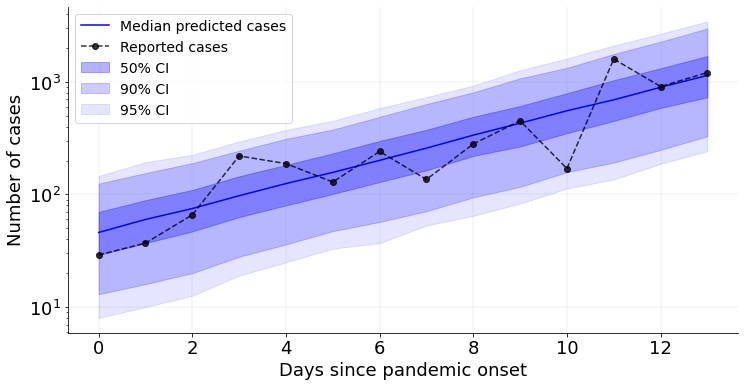

In [168]:
samples = amortizer.sample(
    {'summary_conditions': np.log1p(obs_data).astype(np.float32)[np.newaxis, :, np.newaxis],
     'direct_conditions' : np.ones((1, 5)).astype(np.float32)},                      
     n_samples=3000, to_numpy=True
)
samples = samples[np.sum(samples < 0, axis=1) == 0]
f = plot_median_predictions(samples, obs_data)

d:\anaconda3\envs\tensorflowdev\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


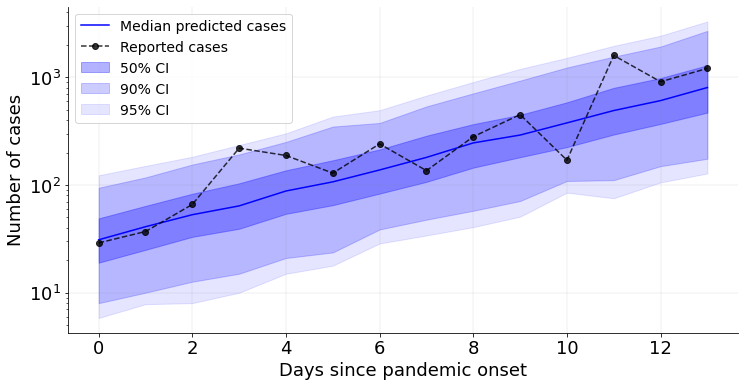

In [114]:
samples = amortizer.sample(
    {'summary_conditions': np.log1p(obs_data).astype(np.float32)[np.newaxis, :, np.newaxis],
     'direct_conditions' : 2 * np.ones((1, 5)).astype(np.float32)},                      
     n_samples=1000, to_numpy=True
)
samples = samples[np.sum(samples < 0, axis=1) == 0]
f = plot_median_predictions(samples, obs_data)

d:\anaconda3\envs\tensorflowdev\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


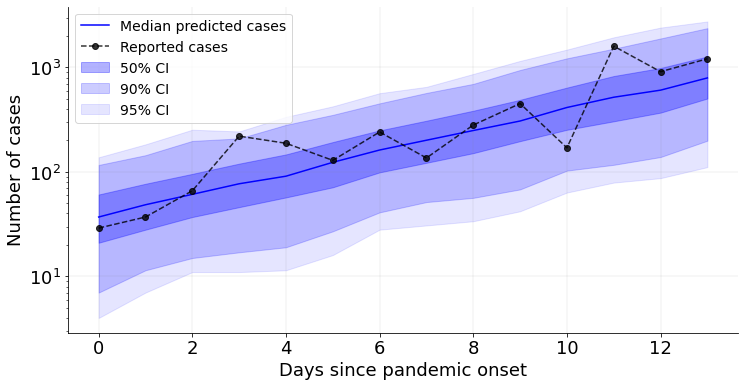

In [115]:
samples = amortizer.sample(
    {'summary_conditions': np.log1p(obs_data).astype(np.float32)[np.newaxis, :, np.newaxis],
     'direct_conditions' : 0.5 * np.ones((1, 5)).astype(np.float32)},                      
     n_samples=1000, to_numpy=True
)
samples = samples[np.sum(samples < 0, axis=1) == 0]
f = plot_median_predictions(samples, obs_data)

In [169]:
param_names = [r'$\lambda$', r'$\mu$', r'$D$', r'$I_0$', r'$\psi$']

In [225]:
samples_alpha = []
for alpha in [0.5, 1, 2]:

    samples = amortizer.sample(
        {'summary_conditions': np.log1p(obs_data).astype(np.float32)[np.newaxis, :, np.newaxis],
         'direct_conditions' : alpha * np.ones((1, 5)).astype(np.float32)},                      
         n_samples=5000, to_numpy=True
    )
    samples = pd.DataFrame(samples[np.sum(samples < 0, axis=1) == 0], columns=param_names)
    samples_alpha.append(samples)

In [226]:
df_all = pd.concat(samples_alpha, axis=0)

In [227]:
df_all['Scaling factor'] = [r'$\alpha = 0.5$'] * len(samples_alpha[0]) \
            + [r'$\alpha = 1.0$'] * len(samples_alpha[1]) \
            + [r'$\alpha = 2.0$'] * len(samples_alpha[2])

In [228]:
def build_viridis_palette(n, n_total=20, base_palette="viridis"):
    """
    Builds a viridis palette with maximal entropy (evenly spaced)
    """
    color_palette = np.array(sns.color_palette(base_palette, n_colors=n_total))
    indices = np.array(np.floor(np.linspace(0, n_total-1, n)), dtype=np.int32)
    color_palette = color_palette[indices]
    return [tuple(c) for c in color_palette]

In [229]:
colors = build_viridis_palette(21, base_palette="plasma")

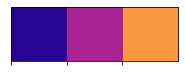

In [230]:
color_codes = {
    r'$\alpha = 0.5$' : colors[0],
    r'$\alpha = 1.0$' : colors[8],
    r'$\alpha = 2.0$' : colors[16],
    
}
sns.palplot(color_codes.values())

[None, None, None, None, None, None]

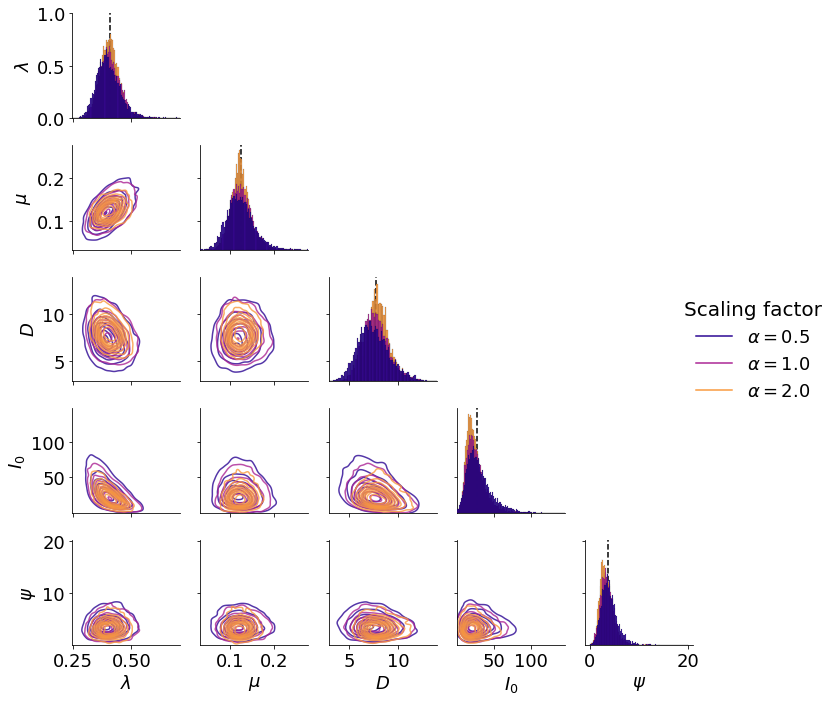

In [262]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r),
                xy=(.25, .5), xycoords=ax.transAxes, fontsize=20)

    
plt.rcParams['font.size'] = 18
grid = sns.PairGrid(df_all, height = 2, hue='Scaling factor', palette=color_codes)
grid = grid.map_diag(sns.histplot, alpha=0.9, fill=True)
grid = grid.map_lower(sns.kdeplot, n_levels=10, cut=0, bw_method='silverman', alpha=0.8)
# grid = grid.map_upper(corrfunc)

for i, j in zip(*np.triu_indices_from(grid.axes, 1)):
    grid.axes[i, j].axis('off')
    
for i in range(len(param_names)):
    grid.axes[i, i].axvline(df_all.iloc[:, i].mean(), color='black', linestyle='dashed')

grid.add_legend()
plt.setp(grid._legend.get_title(), fontsize=20)
plt.setp(grid._legend.get_texts(), fontsize=18)

In [263]:
grid.savefig("Initial_Pairs.png", dpi=300)

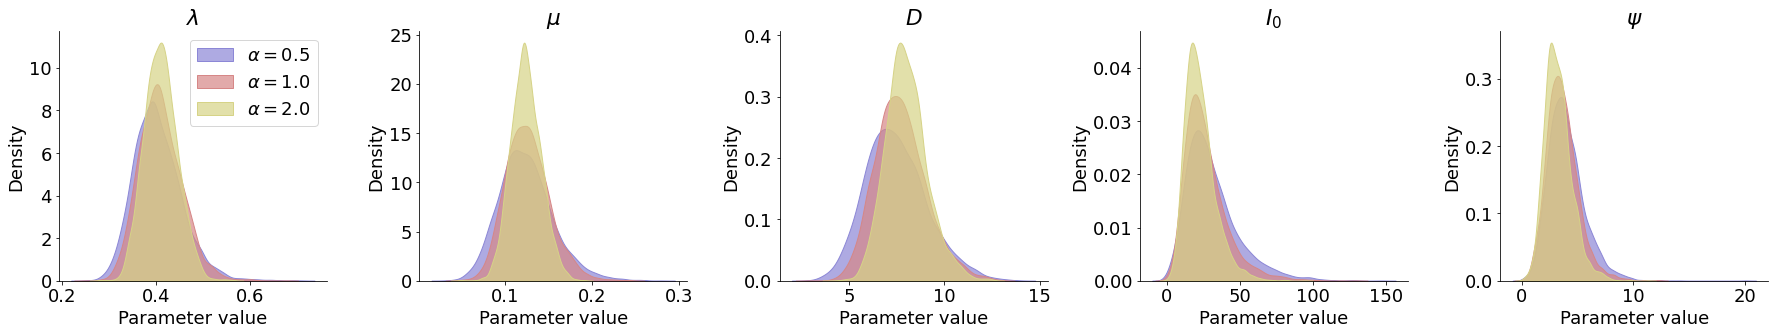

In [267]:
colors = ['#8c87d6', '#d68787', '#d6d387']
legends = [r'$\alpha = 0.5$', r'$\alpha = 1.0$', r'$\alpha = 2.0$']
f, axarr = plt.subplots(1, 5, figsize=(25, 5))
for samples, legend, color in zip(samples_alpha, legends, colors):
    for i, ax in enumerate(axarr):
        l = legend
        sns.kdeplot(samples.values[:, i], ax=ax, alpha=0.7, label=l, fill=True, color=color)
        sns.despine(ax=ax)

for i, ax in enumerate(axarr):
    if i == 0:
        ax.legend()
    ax.set_title(param_names[i])
    ax.set_xlabel('Parameter value')
f.tight_layout()

In [268]:
f.savefig("Initial_Marginal.png", dpi=300)